In [66]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd
# import tensorflow_probability as tfp


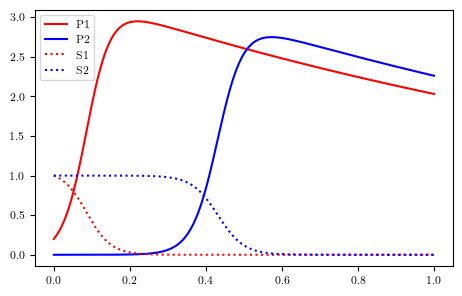

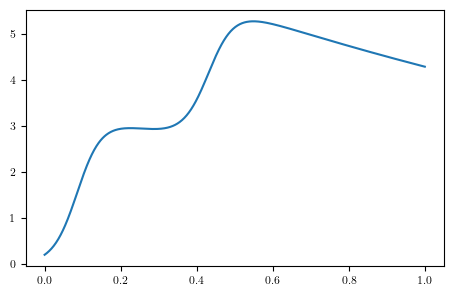

In [67]:
Nt=1000
P1=np.zeros(Nt)
P2=np.zeros(Nt)
S1=np.zeros(Nt)
S2=np.zeros(Nt)
T=np.zeros(Nt)

dt=0.001

m1=30
m2=10
m3=0.0005
m=0.5

P1[0]=0.2 #Initial conditions
P2[0]=0 #Initial conditions
S1[0]=1
S2[0]=1
T[0]=0
for i in range(1,Nt):
    
    P1[i]=P1[i-1]+ (m1*P1[i-1]*S1[i-1]- m3*S2[i-1]*P1[i-1]-m*P1[i-1])*dt
    P2[i]=P2[i-1]+ (m1*P2[i-1]*S2[i-1]+ m3*S2[i-1]*P1[i-1]-m*P2[i-1])*dt
    S1[i]=S1[i-1]- m2*P1[i-1]*S1[i-1]*dt
    S2[i]=S2[i-1]- m2*P2[i-1]*S2[i-1]*dt
    T[i]=T[i-1]+dt

plt.plot(T,P1,c='r', label='P1')
plt.plot(T,P2,c='b', label='P2')

plt.plot(T,S1,c='r', linestyle=':', label='S1')
plt.plot(T,S2,c='b', linestyle=':', label='S2')
plt.legend()
plt.show()

plt.plot(T,P2+P1, label='PT')
plt.show()


In [68]:
N_f = 300 # Number of residual point
N_d = 300 #Number of data

P_star = (P1+P2).T.flatten().reshape([-1,1])
T_star = T.reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx1 = [T_star[0]]
uu1 = [P_star[0]]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
p_train = np.concatenate((uu1,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
T_inifin_tf= tf.convert_to_tensor([[0],[1]], dtype=tf.float32)

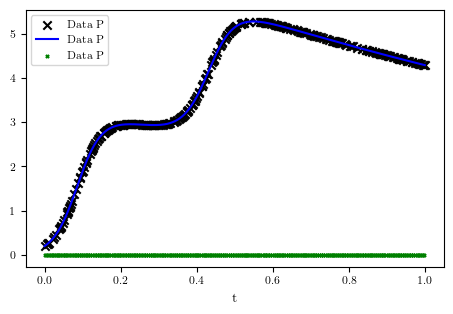

In [69]:
plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')
plt.plot(T_star, P_star, color='blue',label='Data P')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [ ]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std, dtype=tf.float32))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1)),  dtype=tf.float32) 
    alpha_r1 = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_r2 = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_s1 = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_s2 = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    alpha_a = tf.Variable(tf.reshape(tf.repeat(1000.0, 1), (1, -1)), dtype=tf.float32) 
    return alpha_r1,alpha_r2, alpha_b, alpha_s1, alpha_s2, alpha_a

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, lnm1, lnm2, lnm3, lnm, W_p, b_p):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)

        lnp1=u[:,0:1]
        lnp2=u[:,1:2]
        lns1=u[:,2:3]
        lns2=u[:,3:4]

        p1=tf.exp(lnp1)
        p2=tf.exp(lnp2)
        s1=tf.exp(lns1)
        s2=tf.exp(lns2)

        m1=tf.exp(lnm1)[0]
        m2=tf.exp(lnm2)[0]
        m3=tf.exp(lnm3)[0]
        m=tf.exp(lnm)[0]


        p1_t=tape1.gradient(p1, t)
        p2_t=tape1.gradient(p2, t)
        s1_t=tape1.gradient(s1, t)
        s2_t=tape1.gradient(s2, t)



    f_p1 = p1_t - m1[0]*s1*p1 + m3[0]*s2*p1 + m[0]*p1
    f_p2 = p2_t - m1[0]*s2*p2 - m3[0]*s2*p1 + m[0]*p2
    f_s1 = s1_t + m2[0]*p1*s1
    f_s2 = s2_t + m2[0]*p2*s2

    return f_p1, f_p2, f_s1, f_s2


# @tf.function()
def train_step(W_p, b_p, X_u_train_tf, p_train_tf, X_f_train_tf, lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a,lnm1, lnm2, lnm3, lnm, T_inifin_tf, opt):
        
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, lnm1, lnm2, lnm3, lnm, lambda_r1,lambda_r2, lambda_b, lambda_s1, lambda_s2, lambda_a])
        u_nn = net(t_u, W_p, b_p) 
        lnp1=u_nn[:,0:1]
        lnp2=u_nn[:,1:2]
        p1_nn=tf.exp(lnp1)
        p2_nn=tf.exp(lnp2)
        u_nn_0 = net(T_inifin_tf, W_p, b_p) 
     
        p2_0=tf.exp(u_nn_0[:,1:2])
        s1_0=tf.exp(u_nn_0[:,2:3])
        s2_0=tf.exp(u_nn_0[:,3:4])

        f_p1, f_p2, f_s1, f_s2 = net_f(t_f, lnm1, lnm2, lnm3, lnm, W_p, b_p)

        loss_p = tf.square(lambda_b*(p1_nn + p2_nn - p_train_tf))
        loss_s10 = tf.square(lambda_a*(1 - s1_0[0]))
        loss_s11 = tf.square(lambda_a*(0 - s1_0[1]))
        loss_s20 = tf.square(lambda_a*(1 - s2_0[0]))
        loss_s21 = tf.square(lambda_a*(0 - s2_0[1]))
        loss_p20 = tf.square(lambda_a*(0 - p2_0[0]))
        loss_fp1 = tf.square(lambda_r1*f_p1) 
        loss_fp2 = tf.square(lambda_r2*f_p2) 

        loss_fs1 = tf.square(lambda_s1*f_s1) 
        loss_fs2 = tf.square(lambda_s2*f_s2) 
        # loss_fa = tf.square(lambda_a*f_a) 

        # loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_s10) + tf.reduce_mean(loss_s20) + tf.reduce_mean(loss_a0) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs1) + tf.reduce_mean(loss_fs2) + tf.reduce_mean(loss_fa)
        loss =  tf.reduce_mean(loss_p) +tf.reduce_mean(loss_p20) + tf.reduce_mean(loss_s10) +tf.reduce_mean(loss_s20) + tf.reduce_mean(loss_s11) + tf.reduce_mean(loss_s21) + tf.reduce_mean(loss_fp1)+ tf.reduce_mean(loss_fs1) + tf.reduce_mean(loss_fs2) + tf.reduce_mean(loss_fp2)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_m1 = tape.gradient(loss, lnm1)
    grads_m2 = tape.gradient(loss, lnm2)
    grads_m3 = tape.gradient(loss, lnm3)
    grads_m = tape.gradient(loss, lnm)

    grads_la = tape.gradient(loss, lambda_a)
    grads_ls1 = tape.gradient(loss, lambda_s1)
    grads_ls2 = tape.gradient(loss, lambda_s2)

    grads_lr1 = tape.gradient(loss, lambda_r1)
    grads_lr2 = tape.gradient(loss, lambda_r2)

    grads_lb = tape.gradient(loss, lambda_b)




    # grads_m = tape.gradient(loss, m)

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip([grads_m1], [lnm1]))
    opt.apply_gradients(zip([grads_m2], [lnm2]))
    opt.apply_gradients(zip([grads_m3], [lnm3]))
    opt.apply_gradients(zip([grads_m], [lnm]))

    opt.apply_gradients(zip([-grads_la], [lambda_a]))
    opt.apply_gradients(zip([-grads_ls1], [lambda_s1]))
    opt.apply_gradients(zip([-grads_ls2], [lambda_s2]))

    opt.apply_gradients(zip([-grads_lr1], [lambda_r1]))
    opt.apply_gradients(zip([-grads_lr2], [lambda_r2]))

    opt.apply_gradients(zip([-grads_lb], [lambda_b]))




    # opt.apply_gradients(zip(grads_m, m))
   
    return loss, tf.reduce_mean(loss_p), tf.reduce_mean(loss_fp1), tf.reduce_mean(loss_fp2), tf.reduce_mean(loss_fs1), tf.reduce_mean(loss_fs2)



layers = [1, 10, 10, 4]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]]), dtype=tf.float32) for l in range(1, L)]


lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a = loss_weight(N_f, N_d)
lnm1 = tf.Variable(tf.ones([1,1]), dtype=tf.float32)
lnm2 = tf.Variable(tf.ones([1,1]), dtype=tf.float32)
lnm3 = tf.Variable(tf.ones([1,1]), dtype=tf.float32)
lnm = tf.Variable(tf.ones([1,1]), dtype=tf.float32)


In [71]:
lnm1

<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>

In [ ]:
from scipy.optimize import minimize

def custom_loss_function(params, X_u_train_tf, p_train_tf, X_f_train_tf, T_inifin_tf, W_shapes, b_shapes):
    # Divide los parámetros optimizados en los pesos, sesgos y variables adicionales
    offset = 0
    W_p = []
    for shape in W_shapes:
        size = shape[0] * shape[1]
        W_p.append(tf.reshape(params[offset:offset + size], shape))
        offset += size
    b_p = []
    for shape in b_shapes:
        size = shape[1]
        b_p.append(tf.reshape(params[offset:offset + size], shape))
        offset += size
    
    # Extraer lnm y lambdas de los parámetros
    lnm1, lnm2, lnm3, lnm = params[offset:offset+4]
    offset += 4
    lambda_r1, lambda_r2, lambda_b, lambda_s1, lambda_s2, lambda_a = params[offset:offset+6]

    # Calcula las componentes de la pérdida
    t_u = X_u_train_tf
    t_f = X_f_train_tf
    u_nn = net(t_u, W_p, b_p)
    lnp1 = u_nn[:, 0:1]
    lnp2 = u_nn[:, 1:2]
    p1_nn = tf.exp(lnp1)
    p2_nn = tf.exp(lnp2)
    u_nn_0 = net(T_inifin_tf, W_p, b_p)

    p2_0 = tf.exp(u_nn_0[:, 1:2])
    s1_0 = tf.exp(u_nn_0[:, 2:3])
    s2_0 = tf.exp(u_nn_0[:, 3:4])

    f_p1, f_p2, f_s1, f_s2 = net_f(t_f, lnm1, lnm2, lnm3, lnm, W_p, b_p)

    # Componentes de pérdida
    loss_p = tf.square(lambda_b * (p1_nn + p2_nn - p_train_tf))
    loss_s10 = tf.square(lambda_a[0] * (1 - s1_0[0]))
    loss_s11 = tf.square(lambda_a[1] * (0 - s1_0[1]))
    loss_s20 = tf.square(lambda_a[2] * (1 - s2_0[0]))
    loss_s21 = tf.square(lambda_a[3] * (0 - s2_0[1]))
    loss_p20 = tf.square(lambda_a[4] * (0 - p2_0[0]))
    loss_fp1 = tf.square(lambda_r1 * f_p1)
    loss_fp2 = tf.square(lambda_r2 * f_p2)
    loss_fs1 = tf.square(lambda_s1 * f_s1)
    loss_fs2 = tf.square(lambda_s2 * f_s2)

    # Pérdida total
    total_loss = (tf.reduce_mean(loss_p) + tf.reduce_mean(loss_p20) +
                  tf.reduce_mean(loss_s10) + tf.reduce_mean(loss_s20) +
                  tf.reduce_mean(loss_s11) + tf.reduce_mean(loss_s21) +
                  tf.reduce_mean(loss_fp1) + tf.reduce_mean(loss_fp2) +
                  tf.reduce_mean(loss_fs1) + tf.reduce_mean(loss_fs2))
    return total_loss

def lbfgs_refinement(W_p, b_p, X_u_train_tf, p_train_tf, X_f_train_tf, T_inifin_tf, lnm1, lnm2, lnm3, lnm, lambda_r1, lambda_r2, lambda_b, lambda_s1, lambda_s2, lambda_a):

    # Obtener las formas de W_p y b_p
    W_shapes = [w.shape for w in W_p]
    b_shapes = [b.shape for b in b_p]

    # Vector inicial de parámetros
    initial_params = tf.concat(
    [tf.reshape(w, [-1]) for w in W_p + b_p] + 
    [tf.reshape(param, [-1]) for param in [lnm1, lnm2, lnm3, lnm, lambda_r1, lambda_r2, lambda_b, lambda_s1, lambda_s2, lambda_a]],
    axis=0).numpy()
    initial_params = tf.cast(initial_params, tf.float32)



    # Función de pérdida y gradientes
    def loss_and_gradients(params):
        loss_value = custom_loss_function(params, X_u_train_tf, p_train_tf, X_f_train_tf, T_inifin_tf, W_shapes, b_shapes)
        with tf.GradientTape() as tape:
            tape.watch(params)
            loss_value = custom_loss_function(params, X_u_train_tf, p_train_tf, X_f_train_tf, T_inifin_tf, W_shapes, b_shapes)
        grads = tape.gradient(loss_value, params)
        return loss_value.numpy(), grads.numpy()

    # Ejecuta L-BFGS
    result = minimize(loss_and_gradients, initial_params, jac=True, method='L-BFGS-B', options={'maxiter': 500, 'disp': True})

    # Divide el vector optimizado en W_p, b_p y otros parámetros
    offset = 0
    for i in range(len(W_p)):
        shape = W_p[i].shape
        size = shape[0] * shape[1]
        W_p[i].assign(tf.reshape(result.x[offset:offset + size], shape))
        offset += size
    for i in range(len(b_p)):
        shape = b_p[i].shape
        size = shape[1]
        b_p[i].assign(tf.reshape(result.x[offset:offset + size], shape))
        offset += size

    # Actualizar lnm y lambdas
    lnm1.assign(result.x[offset])
    lnm2.assign(result.x[offset + 1])
    lnm3.assign(result.x[offset + 2])
    lnm.assign(result.x[offset + 3])
    lambda_r1.assign(result.x[offset + 4])
    lambda_r2.assign(result.x[offset + 5])
    lambda_b.assign(result.x[offset + 6])
    lambda_s1.assign(result.x[offset + 7])
    lambda_s2.assign(result.x[offset + 8])
    lambda_a.assign(result.x[offset + 9])

    # Verificar la pérdida final después del refinamiento
    loss_final = custom_loss_function(result.x, X_u_train_tf, p_train_tf, X_f_train_tf, T_inifin_tf, W_shapes, b_shapes)
    print("Final loss after L-BFGS refinement:", loss_final.numpy())


In [73]:
loss = []
loss_p = []
loss_fp1 = []
loss_fp2 = []
loss_fs1 = []
loss_fs2 = []
n=0


In [82]:
lr = 1e-3
# Nmax = 15000
Nmax = 150000
Nmax=10**4
# Nmax=19000


# optimizer2 = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0)

optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)

# optimizer2 = tf.optimizers.lbfgs_minimize()




start_time = time.time()

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a,lnm1, lnm2, lnm3, lnm,T_inifin_tf, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a,lnm1, lnm2, lnm3, lnm,T_inifin_tf, optimizer2)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a,lnm1, lnm2, lnm3, lnm,T_inifin_tf, optimizer3)


while n <= Nmax:
    if n<2*10**4:
    
        loss_, loss_p_, loss_fp1_, loss_fp2_, loss_fs1_, loss_fs2_= train_step_1(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a,lnm1, lnm2, lnm3, lnm,T_inifin_tf)
    elif n< 10**5:
        loss_, loss_p_, loss_fp1_, loss_fp2_, loss_fs1_, loss_fs2_= train_step_2(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a,lnm1, lnm2, lnm3, lnm,T_inifin_tf)
    else:
        loss_, loss_p_, loss_fp1_, loss_fp2_, loss_fs1_, loss_fs2_= train_step_3(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a,lnm1, lnm2, lnm3, lnm,T_inifin_tf)

    # loss_, loss_p_, loss_fp1_, loss_fp2_, loss_fs1_, loss_fs2_= train_step(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r1,lambda_r2, lambda_b, lambda_s1,lambda_s2, lambda_a,lnm1, lnm2, lnm3, lnm,T_inifin_tf, optimizer)

    loss.append(loss_)
    loss_p.append(loss_p_)
    loss_fp1.append(loss_fp1_)
    loss_fp2.append(loss_fp2_)

    loss_fs1.append(loss_fs1_)
    loss_fs2.append(loss_fs2_)




    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_p_}")
        print(f"Physicial loss of p1 is: {loss_fp1_}")
        print(f"Physicial loss of s is: {loss_fs1_}")
        # print(f"Physicial loss of a is: {loss_fp2_}")


    n+=1


elapsed = time.time() - start_time
print(f'Training time with Adam: {elapsed:.4f} seconds')

(300, 1)
(300, 1)
Iteration is: 3790
Total loss is: 6882004.0
Data loss is: 4359034.5
Physicial loss of p1 is: 5.9039835929870605
Physicial loss of s is: 7.949939727783203
Iteration is: 3800
Total loss is: 5297085.0
Data loss is: 3623282.75
Physicial loss of p1 is: 7.132091522216797
Physicial loss of s is: 5.312582015991211
Iteration is: 3810
Total loss is: 3508229.25
Data loss is: 2371744.0
Physicial loss of p1 is: 10.949320793151855
Physicial loss of s is: 3.416431427001953
Iteration is: 3820
Total loss is: 2169154.5
Data loss is: 1360724.75
Physicial loss of p1 is: 18.611278533935547
Physicial loss of s is: 2.758774757385254
Iteration is: 3830
Total loss is: 1667126.75
Data loss is: 1055675.25
Physicial loss of p1 is: 22.9525203704834
Physicial loss of s is: 3.0338101387023926
Iteration is: 3840
Total loss is: 1279591.625
Data loss is: 738424.875
Physicial loss of p1 is: 21.202198028564453
Physicial loss of s is: 3.412186622619629
Iteration is: 3850
Total loss is: 1090976.375
Data l

KeyboardInterrupt: 

In [76]:

lbfgs_refinement(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, T_inifin_tf, lnm1, lnm2, lnm3, lnm, lambda_r1, lambda_r2, lambda_b, lambda_s1, lambda_s2, lambda_a)

InvalidArgumentError: cannot compute MatMul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:MatMul]

In [77]:
print([w.dtype for w in W_p])  # Verifica tipos de W_p
print([b.dtype for b in b_p])  # Verifica tipos de b_p
print(T_u_train_tf.dtype)
print(p_train_tf.dtype)
print(T_f_train_tf.dtype)
print(T_inifin_tf.dtype)
print(lnm1.dtype)
print(lnm2.dtype)
print(lnm3.dtype)
print(lnm.dtype)
print(lambda_r1.dtype)
print(lambda_r2.dtype)
print(lambda_b.dtype)
print(lambda_s1.dtype)
print(lambda_s2.dtype)
print(lambda_a.dtype)


[tf.float32, tf.float32, tf.float32]
[tf.float32, tf.float32, tf.float32]
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>


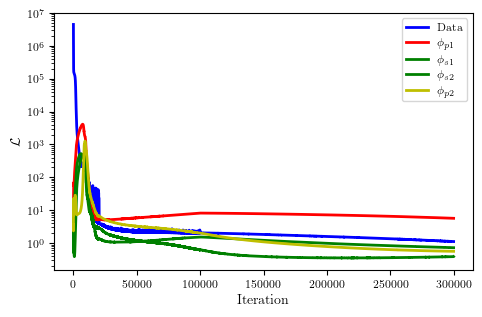

In [70]:
Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_p_list = [loss_p[i].numpy() for i in range(0,Nmax)]
loss_fp1_list = [loss_fp1[i].numpy() for i in range(0,Nmax)]
loss_fp2_list = [loss_fp2[i].numpy() for i in range(0,Nmax)]
loss_fs1_list = [loss_fs1[i].numpy() for i in range(0,Nmax)]
loss_fs2_list = [loss_fs2[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_p_list), 'b-', linewidth = 2, label = 'Data')  
plt.semilogy(it, np.asarray(loss_fp1_list), 'r-', linewidth = 2, label = '$\phi_{p1}$')    
plt.semilogy(it, np.asarray(loss_fs1_list), 'g-', linewidth = 2, label = '$\phi_{s1}$')  
plt.semilogy(it, np.asarray(loss_fs2_list), 'g-', linewidth = 2, label = '$\phi_{s2}$')    
plt.semilogy(it, np.asarray(loss_fp2_list), 'y-', linewidth = 2, label = '$\phi_{p2}$')       



plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [71]:
m1=tf.exp(lnm1)[0]
m2=tf.exp(lnm2)[0]
m3=tf.exp(lnm3)[0]
m=tf.exp(lnm)[0]

In [72]:
lnm3, np.log(0.0005)

([<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-12.367146]], dtype=float32)>],
 -7.600902459542082)

In [73]:
m1, m2, m3, m

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[29.911299]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.923275]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.25615e-06]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.52407]], dtype=float32)>)

In [74]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star, dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp1=u_pred[:,0:1]
lnp2=u_pred[:,1:2]
lns1=u_pred[:,2:3]
lns2=u_pred[:,3:4]

p1=tf.exp(lnp1)
p2=tf.exp(lnp2)
s1=tf.exp(lns1)
s2=tf.exp(lns2)
# a=tf.exp(lna)
# phi_p = predict(tf.concat([p, s, a],1), W_phip, b_phip)
# phi_a = predict(tf.concat([p, a],1), W_phia, b_phia)
phi_p1= m1*s1*p1 - m3*s2*p1 - m*p1
phi_p2= m1*s2*p2 + m3*s2*p1 - m*p2

phi_s1=-m2*s1*p1
phi_s2=-m2*s2*p2


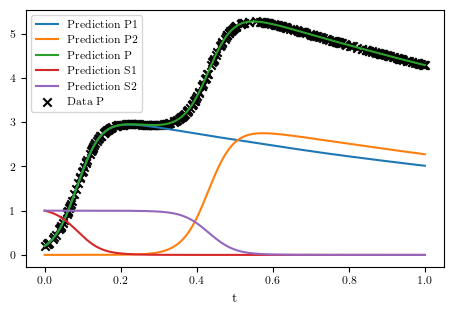

In [75]:
plt.plot(T_star_tf, p1, label='Prediction P1')
plt.plot(T_star_tf, p2, label='Prediction P2')
plt.plot(T_star_tf, p1+p2, label='Prediction P')


plt.plot(T_star_tf, s1, label='Prediction S1')
plt.plot(T_star_tf, s2, label='Prediction S2')


# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

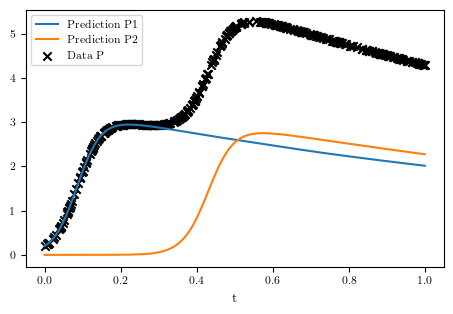

In [76]:
plt.plot(T_star_tf, p1, label='Prediction P1')
plt.plot(T_star_tf, p2, label='Prediction P2')



# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

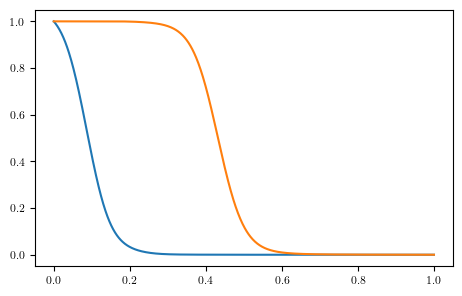

In [77]:
plt.plot(T_star_tf, s1, label='Prediction S1')
plt.plot(T_star_tf, s2, label='Prediction S2')
plt.show()


In [78]:
p1[0], p2[0]

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2021111], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00045116], dtype=float32)>)

In [79]:
Nt=10000
T_int=np.zeros(Nt)
P1_int=np.zeros(Nt)
P2_int=np.zeros(Nt)

S1_int=np.zeros(Nt)
S2_int=np.zeros(Nt)

dt=0.0001
T_int[0]=0
P1_int[0]=np.array(p1[0])
P2_int[0]=np.array(p2[0])

S1_int[0]=np.array(s1[0])
S2_int[0]=np.array(s2[0])

for i in range(1,Nt):
    
    P1_int[i]=P1_int[i-1]+ (m1*P1_int[i-1]*S1_int[i-1]- m3*S2_int[i-1]*P1_int[i-1]-m*P1_int[i-1])*dt
    P2_int[i]=P2_int[i-1]+ (m1*P2_int[i-1]*S2_int[i-1]+ m3*S2_int[i-1]*P1_int[i-1]-m*P2_int[i-1])*dt
    S1_int[i]=S1_int[i-1]- m2*P1_int[i-1]*S1_int[i-1]*dt
    S2_int[i]=S2_int[i-1]- m2*P2_int[i-1]*S2_int[i-1]*dt
    T_int[i]=T_int[i-1]+dt



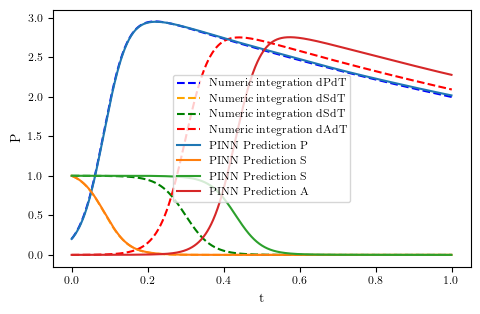

In [80]:
plt.plot(T_int, P1_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S1_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, S2_int, color='green', linestyle='--', label='Numeric integration dSdT')

plt.plot(T_int, P2_int, color='red', linestyle='--', label='Numeric integration dAdT')



plt.plot(T_star_tf, p1, label='PINN Prediction P')
plt.plot(T_star_tf, s1, label='PINN Prediction S')
plt.plot(T_star_tf, s2, label='PINN Prediction S')
plt.plot(T_star_tf, p2, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

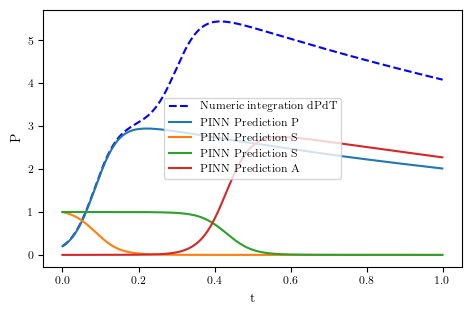

In [81]:
plt.plot(T_int, P1_int+P2_int, color='blue', linestyle='--', label='Numeric integration dPdT')





plt.plot(T_star_tf, p1, label='PINN Prediction P')
plt.plot(T_star_tf, s1, label='PINN Prediction S')
plt.plot(T_star_tf, s2, label='PINN Prediction S')
plt.plot(T_star_tf, p2, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [105]:
Nt=10000
T_int=np.zeros(Nt)
P1_int=np.zeros(Nt)
P2_int=np.zeros(Nt)

S1_int=np.zeros(Nt)
S2_int=np.zeros(Nt)

dt=0.0001
T_int[0]=0
P1_int[0]=np.array(p1[0])
P2_int[0]=np.array(0.00001)

S1_int[0]=np.array(s1[0])
S2_int[0]=np.array(s2[0])

for i in range(1,Nt):
    
    P1_int[i]=P1_int[i-1]+ (m1*P1_int[i-1]*S1_int[i-1]- m3*S2_int[i-1]*P1_int[i-1]-m*P1_int[i-1])*dt
    P2_int[i]=P2_int[i-1]+ (m1*P2_int[i-1]*S2_int[i-1]+ m3*S2_int[i-1]*P1_int[i-1]-m*P2_int[i-1])*dt
    S1_int[i]=S1_int[i-1]- m2*P1_int[i-1]*S1_int[i-1]*dt
    S2_int[i]=S2_int[i-1]- m2*P2_int[i-1]*S2_int[i-1]*dt
    T_int[i]=T_int[i-1]+dt



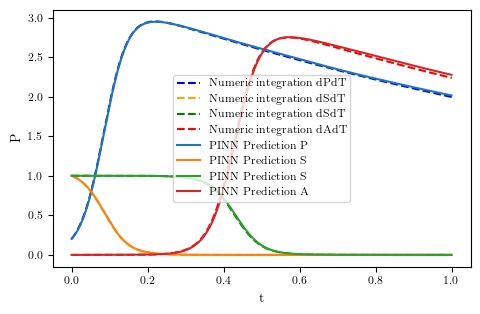

In [106]:
plt.plot(T_int, P1_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S1_int, color='orange', linestyle='--', label='Numeric integration dSdT')
plt.plot(T_int, S2_int, color='green', linestyle='--', label='Numeric integration dSdT')

plt.plot(T_int, P2_int, color='red', linestyle='--', label='Numeric integration dAdT')



plt.plot(T_star_tf, p1, label='PINN Prediction P')
plt.plot(T_star_tf, s1, label='PINN Prediction S')
plt.plot(T_star_tf, s2, label='PINN Prediction S')
plt.plot(T_star_tf, p2, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [108]:
p1.shape, p2.shape

(TensorShape([1000, 1]), TensorShape([1000, 1]))

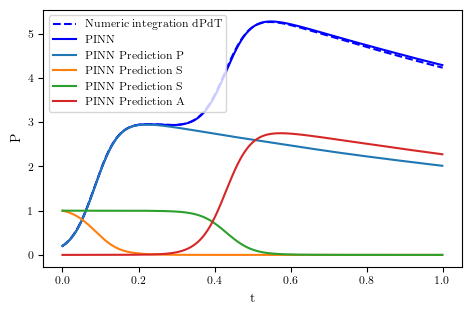

In [107]:
plt.plot(T_int, P1_int+P2_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_star_tf, p1+p2, color='blue', linestyle='-', label='PINN')






plt.plot(T_star_tf, p1, label='PINN Prediction P')
plt.plot(T_star_tf, s1, label='PINN Prediction S')
plt.plot(T_star_tf, s2, label='PINN Prediction S')
plt.plot(T_star_tf, p2, label='PINN Prediction A')

plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

# Symbolic Regresion

In [24]:
# Create and train the PySR model
model_phi = PySRRegressor(
    niterations=500,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    # unary_operators=["inv(x) = 1/x"],
    # extra_sympy_mappings={"inv": lambda x: 1 / x},
    # constraints={"/": (-1, 1)},
    # complexity_of_operators={"/": 2},
    parsimony=0.00001,
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)

In [25]:
# Fit phi
model_phi.fit(tf.concat([p, s, a],1), s)
print(model_phi)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.330e+05
Head worker occupation: 29.9%
Progress: 545 / 7500 total iterations (7.267%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.719e+00  1.594e+01  y = x₁
3           4.513e+00  2.231e-02  y = x₁ * 2.2107
5           3.319e+00  1.537e-01  y = (x₁ * 14.066) + -4.5759
7           2.724e+00  9.868e-02  y = (-4.7893 * x₀) + (x₁ * 11.093)
9           2.447e+00  5.368e-02  y = ((-98.555 + (x₁ * 151.99)) * x₁) + 14.641
11          6.685e-01  6.488e-01  y = ((38.873 * x₁) + ((x₀ + -0.36154) * -31.833)) * x₀
13          6.304e-01  2.937e-02  y = ((((x₀ + -0.41423) * -33.14) + (38.604 * x₁)) * x₀) + -0.8...
                                  1758
15          6.136e-01  1.347e-02  y = (x₀ * (((x₀ + -0.44546) * -36.131) + ((39.684 * x₁) + x₁))...
                                  ) + -1.4102
17          6.025e-01  9.119e-03  y = (x₀ + ((

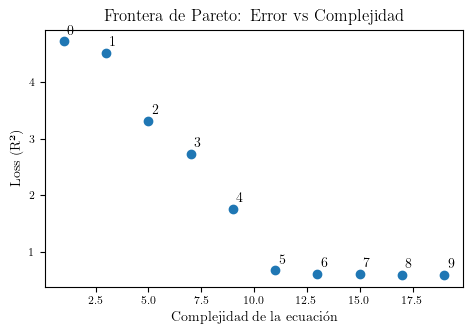

In [26]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

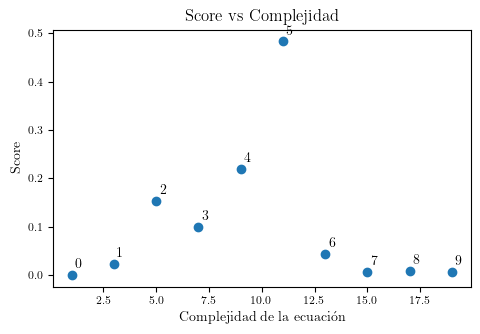

In [27]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [28]:
chose=5
expr=model_phi.sympy(chose)
expr
sympy.expand(expr)

-31.679077*x0**2 + 38.66269*x0*x1 + 11.4634953441741*x0

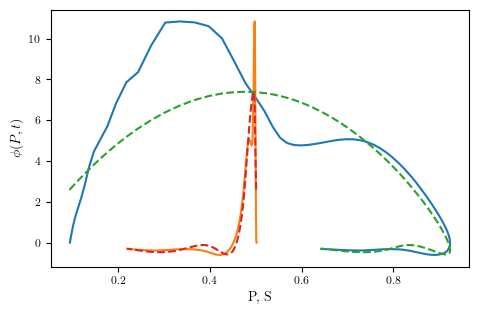

In [29]:
symb1=model_phi.predict(tf.concat([p, s],1),chose)
plt.plot(tf.concat([p, s],1), phi_pred, label='PINN prediction')
plt.plot(tf.concat([p, s],1), symb1, linestyle='--', label='Symbolic regresion')

plt.xlabel('P, S')
plt.ylabel('$\phi (P,t)$')
plt.show()

In [30]:
Nt=10000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)
S_symb=np.zeros(Nt)

dt=0.0001

P_symb[0]=np.mean(uu1) #Initial conditions
S_symb[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions
T_symb[0]=0
for i in range(1,Nt):
    PS_p=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    P_symb[i]=P_symb[i-1]+model_phi.predict(PS_p,chose)*dt
    S_symb[i]=S_symb[i-1]-P_symb[i-1]*np.array(m[0])*dt
    T_symb[i]=T_symb[i-1]+dt

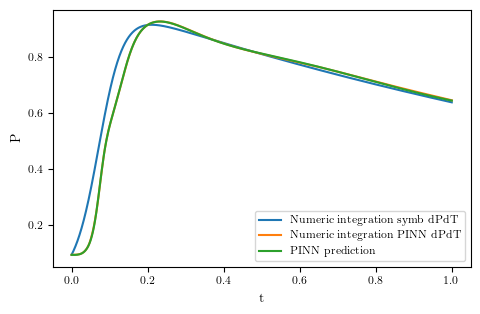

In [35]:
plt.plot(T_symb, P_symb, label='Numeric integration symb dPdT')
plt.plot(T_int, P_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, p, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

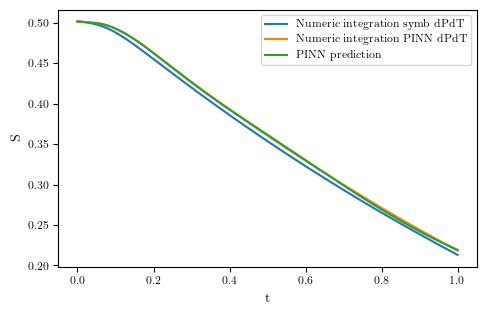

In [36]:
plt.plot(T_symb, S_symb, label='Numeric integration symb dPdT')
plt.plot(T_int, S_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, s, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('S')
plt.legend()
plt.show()